In [1]:
import os, sys
import pandas as pd
import numpy as np
paths_dict = np.load('_utils/paths_dict.npy',allow_pickle='TRUE').item()
maps_dict = np.load('_utils/maps_dict.npy',allow_pickle='TRUE').item()
from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from tqdm import tqdm

def UVJ_condition(UV, VJ, z):
    shift = np.zeros(len(z))
    shift[np.where(z < 0.5)] = 0.69
    shift[np.where((z > 0.5) & (z < 1.0))] = 0.59
    shift[np.where((z > 1.0) & (z < 2.5))] = 0.49
    cond = np.zeros(len(z))
    cond = (UV - 0.88*(VJ + shift) > 0) & (UV > 1.3) & (VJ < 1.6)
    return cond

Quoting Williams et al., 2009:

The adopted diagonal selection criteria for quiescent galaxies between $0 < z < 2$ bin are as follows:
- $(U − V ) > 0.88 \times (V − J )+0.69$ at $[0.0 <z< 0.5]$
- $(U − V ) > 0.88 \times (V − J )+0.59$ at $[0.5 <z< 1.0]$
- $(U − V ) > 0.88 \times (V − J )+0.49$ at $[1.0 <z< 2.0]$

Additional criteria of U −V > 1.3 and V −J < 1.6 are applied to the quiescent galaxies at all redshifts to prevent contamination from unobscured and dusty star-forming galaxies, respectively.

In [2]:
#data = fits.open(paths_dict['maps']+maps_dict['f090w']['path'])
#signal, wcs = data[1].data, WCS(data[1].header)

In [17]:
COSMOS2020 = fits.open(paths_dict['catalogs']+'COSMOS2020_CLASSIC_processed.fits')

In [18]:
COSMOS2020[1].columns

ColDefs(
    name = 'ID'; format = 'K'; null = 999999
    name = 'ALPHA_J2000'; format = 'D'; unit = 'deg'
    name = 'DELTA_J2000'; format = 'D'; unit = 'deg'
    name = 'IRAC_CH1_FLUX'; format = 'E'; unit = 'uJy'
    name = 'IRAC_CH1_FLUXERR'; format = 'E'; unit = 'uJy'
    name = 'IRAC_CH2_FLUX'; format = 'E'; unit = 'uJy'
    name = 'IRAC_CH2_FLUXERR'; format = 'E'; unit = 'uJy'
    name = 'GALEX_FUV_FLUX'; format = 'E'; unit = 'uJy'
    name = 'GALEX_FUV_FLUXERR'; format = 'E'; unit = 'uJy'
    name = 'GALEX_NUV_FLUX'; format = 'E'; unit = 'uJy'
    name = 'GALEX_NUV_FLUXERR'; format = 'E'; unit = 'uJy'
    name = 'lp_zBEST'; format = 'D'
    name = 'lp_type'; format = 'K'; null = 999999
    name = 'lp_zp_2'; format = 'D'
    name = 'lp_zq'; format = 'D'
    name = 'lp_model'; format = 'K'; null = 999999
    name = 'lp_age'; format = 'D'; unit = 'yr'
    name = 'lp_dust'; format = 'D'
    name = 'lp_Attenuation'; format = 'K'; null = 999999
    name = 'lp_MNUV'; format = 'D'; unit

In [ ]:
COSMOS2020 = fits.open(paths_dict['catalogs']+'COSMOS2020_CLASSIC_processed.fits')

sel_columns = ['ID', 'ALPHA_J2000', 'DELTA_J2000', 'lp_zBEST', \
               'lp_mass_med', 'lp_mass_best', 'lp_SFR_med', \
               'CFHT_u_MAG', 'SC_V_MAG', 'UVISTA_J_MAG']

df = pd.DataFrame([COSMOS2020[1].data[f] for f in sel_columns], index = sel_columns).T

In [24]:
df = df[(df.lp_zBEST > 0.2) & (df.lp_zBEST < 2.5)] # Redshift cut
df = df[df['lp_mass_best'] > 9] # Mass cut
df = df.reset_index(drop = True).rename(columns={'ID': 'COSMOS_ID'}) # Cosmos ID.
df['U-V'] = df.CFHT_u_MAG-df.SC_V_MAG
df['V-J'] = df.SC_V_MAG-df.UVISTA_J_MAG
df['UVJcond'] = UVJ_condition(df['U-V'], df['V-J'], df.lp_zBEST) # UVJ cut
df = df[df['UVJcond'] == False]

In [23]:
#plt.figure(figsize = (10, 10))
#plt.plot(df['V-J'][df['UVJcond'] == True], df['U-V'][df['UVJcond'] == True], 'r.')
#plt.plot(df['V-J'][df['UVJcond'] == False], df['U-V'][df['UVJcond'] == False], 'b.')

In [25]:
# Quick (and very dirty) footprint condition
footprint_vertices = [(150.234232394, 2.139056096), (150.234254853, 2.422971026),
                      (150.109252533, 2.422976134), (150.109253879, 2.139060605)]
polygon = Polygon(footprint_vertices)
df['isinfoot'] = [polygon.contains(Point(row['ALPHA_J2000'],row['DELTA_J2000'])) for _, row in tqdm(df.iterrows())]
df = df[df['isinfoot'] == True]

# Save df
df.to_csv('C20_UVJselected_infoot.dat', index = False)

171881it [00:08, 19152.63it/s]


Plot check

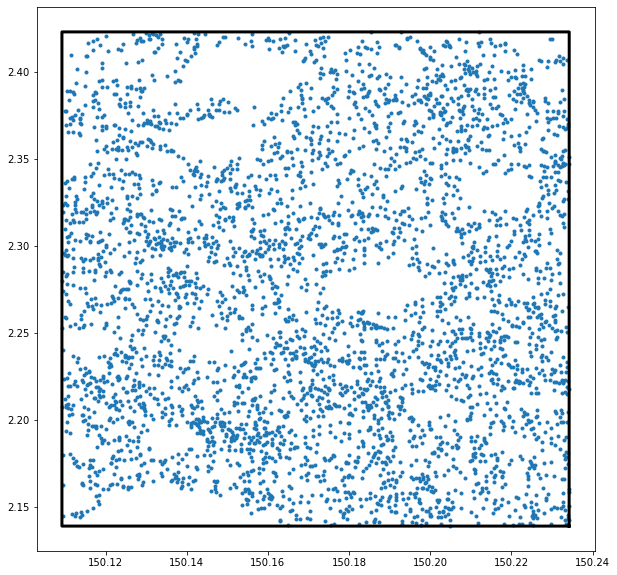

In [26]:
plt.figure(figsize = (10,10))
ax = plt.subplot(111)
ax.plot(df['ALPHA_J2000'][df['UVJcond'] == False], df['DELTA_J2000'][df['UVJcond'] == False], color = 'tab:blue', linewidth = 0, marker = '.')
ax.plot(df['ALPHA_J2000'][df['UVJcond'] == True], df['DELTA_J2000'][df['UVJcond'] == True], color = 'tab:red', linewidth = 0, ms = 10, marker = '.')
ax.plot(*polygon.exterior.xy, color = 'k', linewidth = 3.0)